In [99]:
using Gen
using Flux
using JLD
using Random
using StatsBase
using LinearAlgebra
using PyPlot
using Distributions

include("LoadData.jl")
include("NUTS.jl")
include("proposals.jl")
include("utils.jl");

In [93]:
#Load Boston Housing Data

dx, dy, x_train, x_test, y_train, y_test = load_data(10);

In [157]:
#Network Hyperparameters

#Network hyperparameters
k_real = 4 #Number of hidden nodes per layer
k_vector = [0.0 for i=1:k_real]
k_vector[k_real] = 1.0

#Layer hyperparameters
l_range = 8 #Maximum number of layers in the network
l_list = [Int(i) for i in 1:l_range]
l_real = 1;

#Hyperprior Hyperparameters
αᵧ = 1 #Regression Noise Shape
βᵧ = 1 #Regression Noise Scale/Rate
α₁ = 1 #Input Weights, Biases Shape
β₁ = 1 #Input Weights, Biases Scale/Rate
α₂ = 1 #Hidden & Output Weights Shape
β₂ = k_real #Hidden & Output Weights Scale

4

In [114]:
#Bayesian Neural Network 

function G(x, trace)
    activation = relu
    l = trace[:l]
    ks = [trace[(:k,i)] for i=1:l]
    
    for i=1:l
        in_dim, out_dim = layer_unpacker(i, l, ks)
        W = reshape(trace[(:W,i)], out_dim, in_dim)
        b = reshape(trace[(:b,i)], trace[(:k,i)])
        nn = Dense(W, b, activation)
        x = nn(x)
    end
    
    Wₒ = reshape(trace[(:W,l+1)], 1, ks[l])
    bₒ = reshape(trace[(:b,l+1)], 1)
    
    nn_out = Dense(Wₒ, bₒ)
    return nn_out(x)
end;

In [135]:
#Probabilistic Model

@gen function interpolator(x)
    
    d = length(x[:,1])
    
    #Create a blank choicemap
    obs = choicemap()::ChoiceMap
    
    #Draw number of layers
    l ~ categorical([1/length(l_list) for i=1:length(l_list)])
    l_real = l
    obs[:l] = l
    
    #Create individual weight and bias vectors
    #Loop through hidden layers
    k = [Int(0) for i=1:l+1]
    for i=1:l
        k[i] = @trace(categorical(k_vector), (:k,i))
        obs[(:k,i)] = k[i]
    end
    k[l+1] = @trace(categorical([1.0]), (:k,l+1))
    obs[(:k,l+1)] = k[l+1]
    
    #####################################
    #New hyperparameter schedule - Mar 8#
    #####################################
    
    τ = [0.0 for i=1:l+1]
    τᵦ = [0.0 for i=1:l+1]
    σ = [0.0 for i=1:l+1]
    σᵦ = [0.0 for i=1:l+1]
    
    for i=1:l+1
        if i==1
            τ[i] = @trace(gamma(α₁,β₁), (:τ,i))
            τᵦ[i] = @trace(gamma(α₁,β₁), (:τᵦ,i))
        else
            τ[i] = @trace(gamma(α₂,β₂), (:τ,i))
            τᵦ[i] = @trace(gamma(α₁,β₁), (:τᵦ,i))
        end
        σ[i] = 1/τ[i]
        σᵦ[i] = 1/τᵦ[i]
    end
    
    #Noise Variance
    τᵧ ~ gamma(αᵧ,βᵧ)
    σᵧ = 1/τᵧ
    
    #Sample weight and bias vectors
    W = [zeros(k[i]) for i=1:l+1]
    b = [zeros(k[i]) for i=1:l+1]

    for i=1:l+1
        if i == 1
            h = Int(d * k[i])
        else
            h = Int(k[i-1] * k[i])
        end

        if i<=l
            #Hidden Weights
            u = zeros(h)
            S = Diagonal([σ[i] for j=1:length(u)])::Diagonal{<:Real}
            W[i] = @trace(mvnormal(u,S), (:W,i))
            obs[(:W,i)] = W[i]
            
            #Hidden Biases
            ub = zeros(k[i])
            Sb = Diagonal([σᵦ[i] for j=1:length(ub)])::Diagonal{<:Real}    
            b[i] = @trace(mvnormal(ub,Sb), (:b,i))
            obs[(:b,i)] = b[i]
        else
            #Output Weights
            u = zeros(k[l])
            S = Diagonal([σ[i] for j=1:length(u)])::Diagonal{<:Real}
            W[i] = @trace(mvnormal(u,S), (:W,i))
            obs[(:W,i)] = W[i]

            #Output Bias
            ub = zeros(1)
            Sb = Diagonal([σᵦ[i] for j=1:length(ub)])::Diagonal{<:Real}  
            b[i] = @trace(mvnormal(ub,Sb), (:b,i))
            obs[(:b,i)] = b[i]
        end
    end
    
    #Return Network Scores for X
    scores = transpose(G(x,obs))[:,1]
    
    #Regression Likelihood
    Sy = Diagonal([σᵧ for i=1:length(x[1,:])])::Diagonal{<:Real}
    y = @trace(mvnormal(vec(scores), Sy), (:y))

    return scores
    
end

best_trace = find_best_trace(x_train,y_train,10000);

Best noise variance: 1.7209826713740546
Best MSE: 0.4271897007797358
Best Score: -592.0751775553604
Best layer count: 7


In [ ]:
#Straight NUTS
include("NUTS.jl")
obs_master = choicemap()::ChoiceMap
obs_master[:y] = y_train
obs = obs_master;

Δ_max = 1000
#(trace,) = generate(interpolator, (x_train,), obs)
trace = best_trace
println(trace[:l])
sigma = 1/(trace[:τᵧ]) #Best so far: 3.0483
println("$sigma")

#Trace 1
param_selection = select()

for i=1:trace[:l]+1 #Number of Layers
    push!(param_selection, (:W,i))
    push!(param_selection, (:b,i))
end

m=100

traces = NUTS(trace, param_selection, 0.65, m+1, 2, true); #m+1, m=100, 0.65

plot([get_score(trace) for trace in traces])
plt.title("NUTS Score: Boston Housing Price")
plt.xlabel("Iteration")
plt.ylabel("Log Posterior");

In [249]:
#-------------
#Run Inference
#-------------

include("NUTS.jl")
Δ_max = 1000
acc_prob = 0.65
#Random.seed!(1)

scores = []
traces = []
ks = []
across_acceptance = []
within_acceptance = []

#Inference Hyperparameters
iters = 1
m = 3

@gen function gibbs_hyperparameters(trace)
    obs_new = choicemap()::ChoiceMap
    args = get_args(trace)
    argdiffs = map((_) -> NoChange(), args)
    
    for i=1:trace[:l] + 1
        #Biases
        bias = trace[(:b,i)]
        
        n = length(bias)
        α = α₁ + (n/2)
        
        Σ = sum(bias.^2)/2 
        β = 1/(1/β₁ + Σ)
        
        τᵦ ~ gamma(α,β)
        
        #Weights
        i == 1 ? α₀ = α₁ : α₀ = α₂
        i == 1 ? β₀ = β₁ : β₀ = β₂
        
        weight = trace[(:W,i)]
        
        n = length(weight)
        α = α₀ + (n/2)
        
        Σ = sum(weight.^2)/2
        β = 1/(1/β₀ + Σ)
        
        τ ~ gamma(α,β)
        
        obs_new[(:τ,i)] = τ
        obs_new[(:τᵦ,i)] = τᵦ
    end
    
    (new_trace,_,_,_) = update(trace, args, argdiffs, obs_new)
    
    return new_trace
end

@gen function gibbs_noise(trace)
    obs_new = choicemap()::ChoiceMap
    args = get_args(trace)
    argdiffs = map((_) -> NoChange(), args)
    
    n = length(trace[:y])
    α = αᵧ + (n/2)
    
    x = get_args(trace)[1]
    y_pred = transpose(G(x,trace))[:,1]
    y_real = trace[:y]
    Σᵧ = sum((y_pred .- y_real).^2)/2
    β = 1/(1/βᵧ + Σᵧ)
    
    τ ~ gamma(α,β)
    obs_new[:τᵧ] = τ
    
    (new_trace,_,_,_) = update(trace, args, argdiffs, obs_new)
    
    return new_trace
end

function nuts_parameters(trace)
    
    l = trace[:l]
    param_selection = select()
    for i=1:l+1 #Number of Layers
        push!(param_selection, (:W,i))
        push!(param_selection, (:b,i))
    end
    
    prev_score = get_score(trace)
    
    acc = 0
    for i=1:iters
        new_trace = NUTS(trace, param_selection, acc_prob, m, m, false)[m+1]
        new_score = get_score(new_trace)
        if prev_score != new_score
            return (new_trace, 1)
        else
            return (trace, 0)
        end
    end
    
    return (trace, acc)
end

function layer_parameter(trace)
    obs = obs_master
    for i=1:trace[:l]+1
        obs[(:τ,i)] = trace[(:τ,i)]
        obs[(:τᵦ,i)] = trace[(:τᵦ,i)]
    end
    obs[:τᵧ] = trace[:τᵧ]
    
    init_trace = trace
    
    #################################################RJNUTS#################################################
    #NUTS Step 1
    trace_tilde = trace
    for i=1:iters
        #(trace_tilde,) = propose_hyperparameters(trace_tilde)
        (trace_tilde,) = nuts_parameters(trace_tilde)
    end
    
    #Reversible Jump Step
    (trace_prime, q_weight) = layer_change(trace_tilde)
    
    #NUTS Step 2
    trace_star = trace_prime
    for i=1:iters
        (trace_star,) = nuts_parameters(trace_star)
        #(trace_star,) = propose_hyperparameters(trace_star) 
    end
    #################################################RJNUTS#################################################
        
    model_score = -get_score(init_trace) + get_score(trace_star)
    across_score = model_score + q_weight
    #println(across_score)
    #println(model_score)

    if rand() < exp(across_score)
        println("********** Accepted: $(trace_star[:l]) **********")
        return (trace_star, 1)
    else
        return (init_trace, 0)
    end
end

obs_master = choicemap()::ChoiceMap
obs_master[:y] = y_train
obs = obs_master;

(trace,) = generate(interpolator, (x_train,), obs)
#trace = best_trace

for i=1:20
    (trace, accepted) = layer_parameter(trace)
    push!(across_acceptance, accepted)
    trace  = gibbs_hyperparameters(trace)
    trace  = gibbs_noise(trace)
    (trace, accepted)  = nuts_parameters(trace)
    push!(within_acceptance, accepted)
    push!(scores,get_score(trace))
    push!(traces, trace)
    println("$i : $(get_score(trace))")
    if i%10 == 0
        a_acc = 100*(sum(across_acceptance)/length(across_acceptance))
        w_acc = 100*(sum(within_acceptance)/length(within_acceptance))
        println("Epoch $i A Acceptance Probability: $a_acc %")
        println("Epoch $i W Acceptance Probability: $w_acc %")
    end
end

********** Accepted: 1 **********
1 : -636.6106240698831
2 : -554.8187188287249


InterruptException: InterruptException:

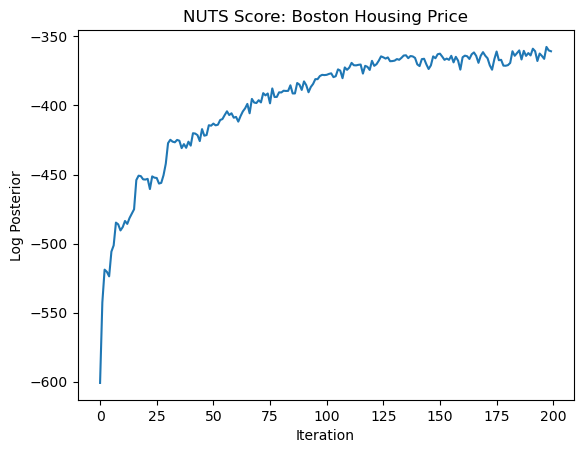

In [243]:
#-----------------------------------
#Plot Log Posterior Scores by Trace
#-----------------------------------

plot([get_score(trace) for trace in traces])
plt.title("NUTS Score: Boston Housing Price")
plt.xlabel("Iteration")
plt.ylabel("Log Posterior");

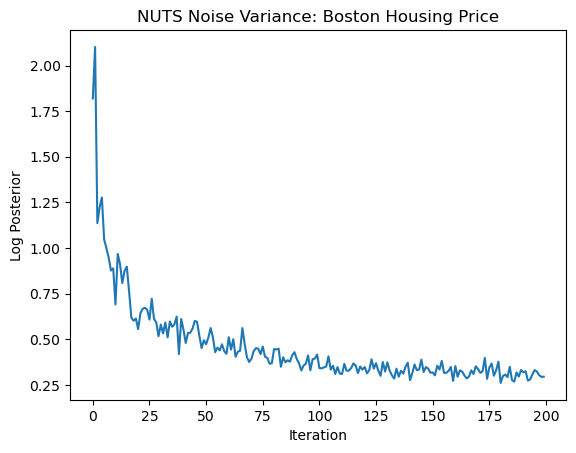

In [244]:
#----------------------------------------
#Plot Regression Noise Variance by Trace
#----------------------------------------

plot([1/trace[:τᵧ] for trace in traces])
plt.title("NUTS Noise Variance: Boston Housing Price")
plt.xlabel("Iteration")
plt.ylabel("Log Posterior");

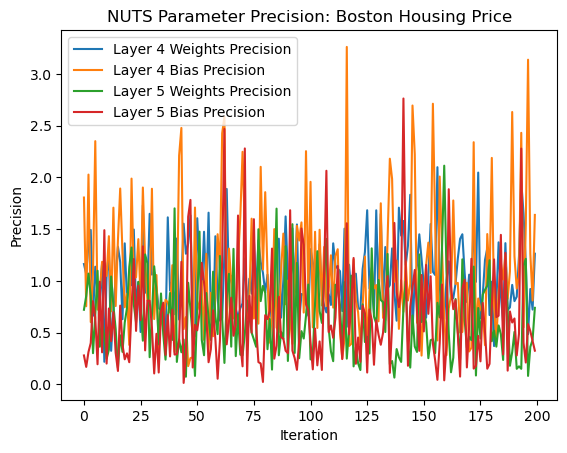

PyObject <matplotlib.legend.Legend object at 0x7fc00fc20e50>

In [248]:
#--------------------------------------------
#Plot Parameter Precision by Trace: Function
#--------------------------------------------

function plot_precision(layer)
    weights = []
    biases = []
    for i=1:length(traces)
        trace = traces[i]
        if layer > trace[:l]+1
            push!(weights,NaN)
            push!(biases,NaN)
        else
            push!(weights,trace[(:τ,layer)])
            push!(biases,trace[(:τᵦ,layer)])
        end
    end
    plot(weights,label=("Layer $layer Weights Precision"))
    plot(biases,label="Layer $layer Bias Precision")
    plt.title("NUTS Parameter Precision: Boston Housing Price")
    plt.xlabel("Iteration")
    plt.ylabel("Precision")
    plt.legend();
end

plot_precision(4)
plot_precision(5)

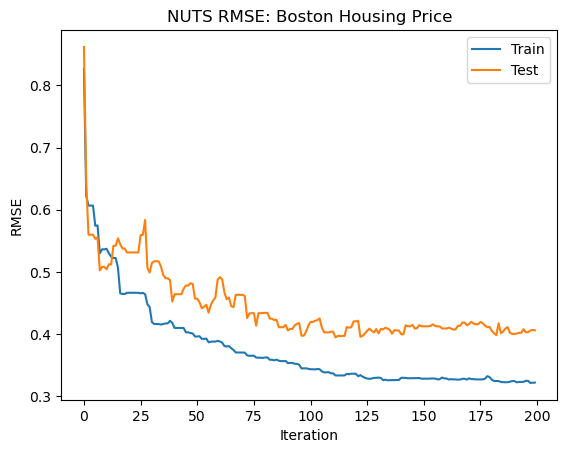

In [245]:
#-------------------------------
#Plot RMSE Train Scores by Trace
#-------------------------------

mses_train = []
for i=1:length(traces)
    trace = traces[i]
    pred_y = transpose(G(x_train,trace))[:,1]
    mse = mse_scaled(pred_y,y_train)

    push!(mses_train,mse)
end

mses_test = []
for i=1:length(traces)
    trace = traces[i]
    pred_y = transpose(G(x_test,trace))[:,1]
    mse = mse_scaled(pred_y,y_test)

    push!(mses_test,mse)
end

plot(mses_train,label="Train")
plot(mses_test, label="Test")
plt.title("NUTS RMSE: Boston Housing Price")
plt.xlabel("Iteration")
plt.ylabel("RMSE");
plt.legend()

best_trace = traces[1]
for i=1:length(traces)
    if get_score(traces[i]) > get_score(best_trace)
        best_trace = traces[i]
    end
end

In [246]:
#----------------
#Marginalize RMSE
#----------------
j = 100
y_marginal = zeros(length(y_train))

for i=j:length(traces)
    trace = traces[i]
    pred_y = transpose(G(x_train,trace))[:,1]
    y_marginal += (pred_y/(length(traces)-j))
end

#display(y_marginal[1:5])
#display(y[1:5])

mse = mse_scaled(y_marginal, y_train)
println("Training Set Marginal RMSE: $mse")

j = 1
y_marginal = zeros(length(y_test))

for i=j:length(traces)
    trace = traces[i]
    pred_y = transpose(G(x_test,trace))[:,1]
    y_marginal += (pred_y/(length(traces)-j))
end

#display(y_marginal[1:5])
#display(y[1:5])

mse = mse_scaled(y_marginal, y_test)
println("Test Set Marginal RMSE: $mse")

Training Set Marginal RMSE: 0.324846438349738
Test Set Marginal RMSE: 0.4194903004931483
